In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

def summary(model):
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    result = []
    for layer in model.layers:
        descriptors = [layer.__class__.__name__, layer.output_shape, layer.count_params()]
        if (type(layer) == Conv2D):
            descriptors.append(layer.padding)
            descriptors.append(layer.activation.__name__)
            descriptors.append(layer.kernel_initializer.__class__.__name__)
        if (type(layer) == MaxPooling2D):
            descriptors.append(layer.pool_size)
        if (type(layer) == Dropout):
            descriptors.append(layer.rate)
        result.append(descriptors)
    return result

def comparator(learner, instructor):
    if len(learner) != len(instructor):
        raise AssertionError(f"The number of layers in the proposed model does not agree with the expected model: expected {len(instructor)}, got {len(learner)}.")
    for a, b in zip(learner, instructor):
        if tuple(a) != tuple(b):
            print(colored("Test failed", attrs=['bold']),
                  "\n Expected value \n\n", colored(f"{b}", "green"),
                  "\n\n does not match the input value: \n\n",
                  colored(f"{a}", "red"))
            raise AssertionError("Error in test")
    print(colored("All tests passed!", "green"))

In [ ]:
import os
import numpy as np
import pandas as pd
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

path = ''
image_path = os.path.join(path, '/content/drive/MyDrive/Filesc4w3a2/Files/tf/W3A2/data/CameraRGB/')
mask_path = os.path.join(path, '/content/drive/MyDrive/Filesc4w3a2/Files/tf/W3A2/data/CameraMask/')
image_list_orig = os.listdir(image_path)
image_list = [image_path+i for i in image_list_orig]
mask_list = [mask_path+i for i in image_list_orig]

<ipython-input-4-548bd8b85d22>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_list[N])
<ipython-input-4-548bd8b85d22>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_list[N])


Text(0.5, 1.0, 'Segmentation')

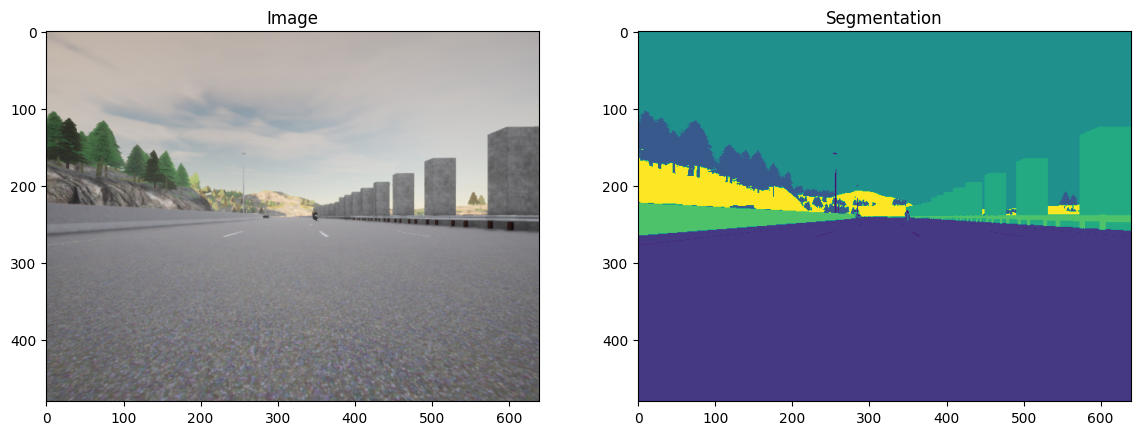

In [ ]:
#SEEING EXAMPLES
N = 2
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

In [ ]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/Filesc4w3a2/Files/tf/W3A2/data/CameraRGB/000026.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/Filesc4w3a2/Files/tf/W3A2/data/CameraMask/000026.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/Filesc4w3a2/Files/tf/W3A2/data/CameraRGB/000027.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/Filesc4w3a2/Files/tf/W3A2/data/CameraMask/000027.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/Filesc4w3a2/Files/tf/W3A2/data/CameraRGB/000028.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/Filesc4w3a2/Files/tf/W3A2/data/CameraMask/000028.png'>)


In [ ]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'/content/drive/MyDrive/Filesc4w3a2/Files/tf/W3A2/data/CameraRGB/049152.png', shape=(), dtype=string)
tf.Tensor(b'/content/drive/MyDrive/Filesc4w3a2/Files/tf/W3A2/data/CameraMask/049152.png', shape=(), dtype=string)


In [ ]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

In [ ]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):

    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  # set 'kernel_initializer' same as above
                  kernel_initializer='he_normal')(conv)


    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)

    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = MaxPooling2D(2)(conv)
    else:
        next_layer = conv

    skip_connection = conv

    return next_layer, skip_connection

In [ ]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):

    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,    # Kernel size
                 strides=2,
                 padding='same')(expansive_input)

    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,   # Number of filters
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,   # Number of filters
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)

    return conv

In [ ]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):

    inputs = Input(input_size)
    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and n_filters
    cblock1 = conv_block(inputs, n_filters)
    # Chain the first element of the output of each block to be the input of the next conv_block.
    # Double the number of filters at each new step
    cblock2 = conv_block(cblock1[0], n_filters*2)
    cblock3 = conv_block(cblock2[0], n_filters*4)
    cblock4 = conv_block(cblock3[0], n_filters*8, dropout_prob=0.3) # Include a dropout_prob of 0.3 for this layer
    # Include a dropout_prob of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False)

    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  n_filters * 8)
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer.
    # At each step, use half the number of filters of the previous block
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters * 4)
    ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters * 2)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters * 1)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 # set 'kernel_initializer' same as above exercises
                 kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [ ]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

In [ ]:
unet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 96, 128, 3)]         0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 96, 128, 32)          896       ['input_4[0][0]']             
                                                                                                  
 conv2d_5 (Conv2D)           (None, 96, 128, 32)          9248      ['conv2d_4[0][0]']            
                                                                                                  
 max_pooling2d_1 (MaxPoolin  (None, 48, 64, 32)           0         ['conv2d_5[0][0]']            
 g2D)                                                                                       

In [ ]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(480, 640, 1)


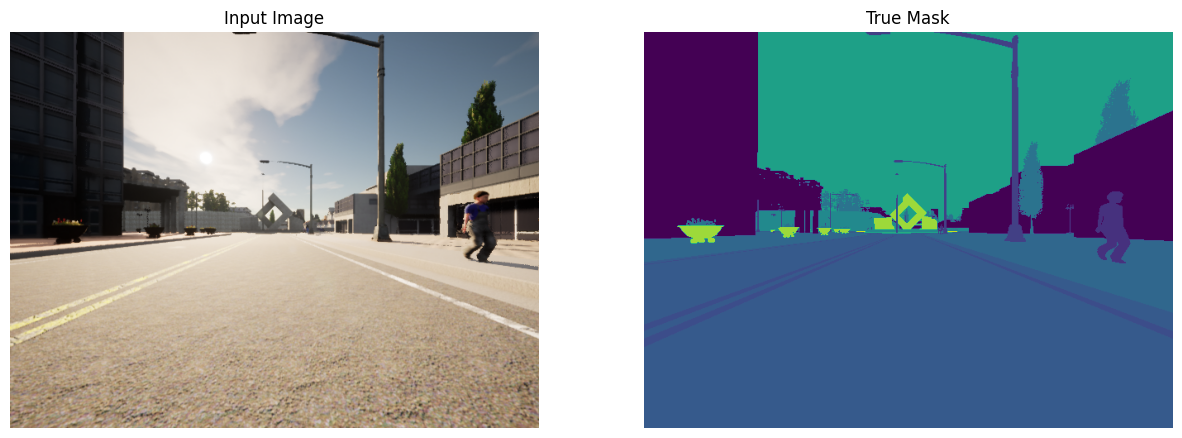

In [ ]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

(96, 128, 1)


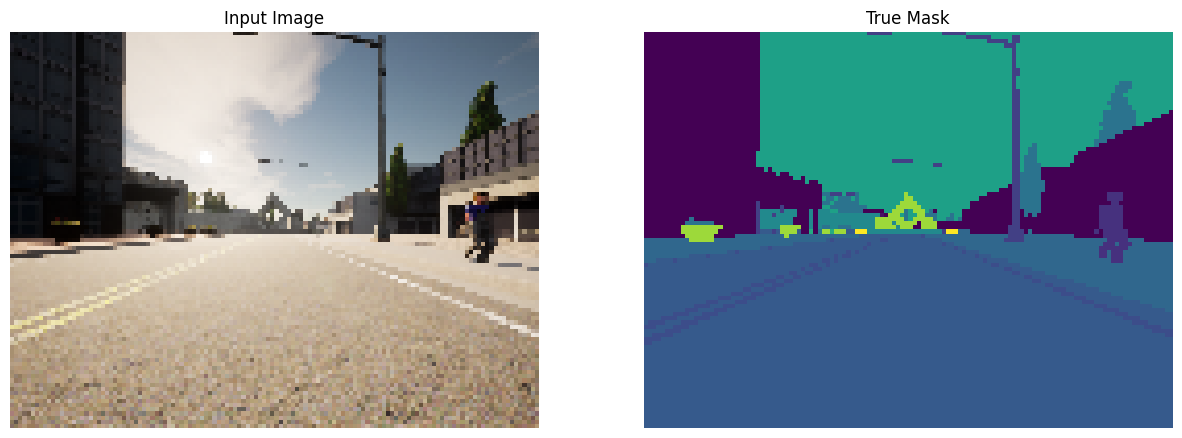

In [ ]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

In [ ]:
EPOCHS = 5
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/5
34/34 [==============================] - 214s 3s/step - loss: 2.0180 - accuracy: 0.4035
Epoch 2/5
34/34 [==============================] - 6s 165ms/step - loss: 1.1045 - accuracy: 0.6878
Epoch 3/5
34/34 [==============================] - 6s 167ms/step - loss: 0.6089 - accuracy: 0.8249
Epoch 4/5
34/34 [==============================] - 6s 166ms/step - loss: 0.5001 - accuracy: 0.8552
Epoch 5/5
34/34 [==============================] - 6s 167ms/step - loss: 0.4119 - accuracy: 0.8797


In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

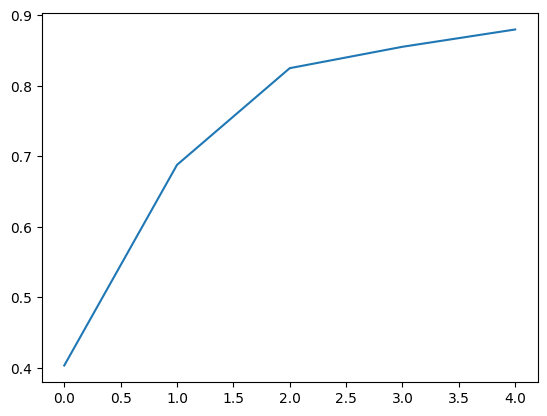

In [ ]:
plt.plot(model_history.history["accuracy"])

In [ ]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 1s 565ms/step


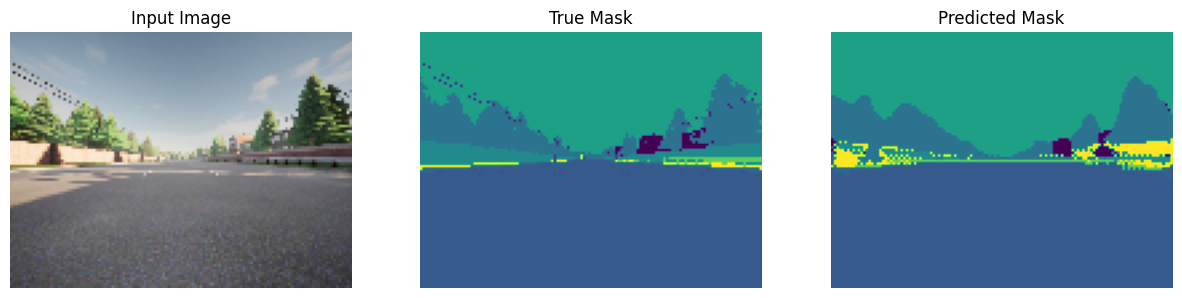

1/1 [==============================] - 0s 25ms/step


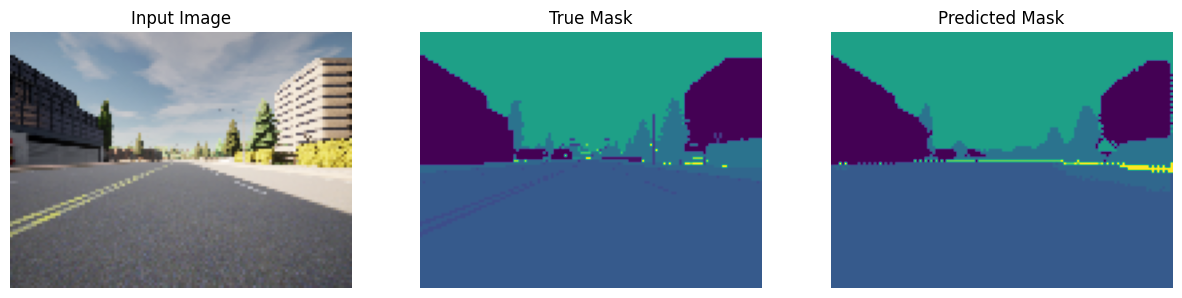

1/1 [==============================] - 0s 45ms/step


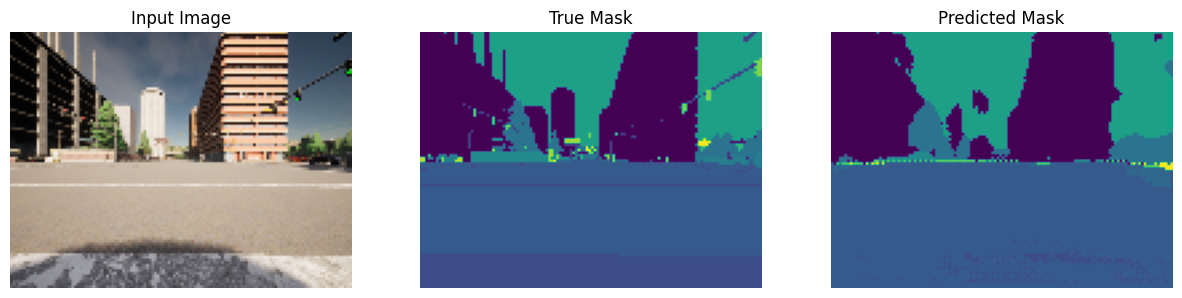

1/1 [==============================] - 0s 31ms/step


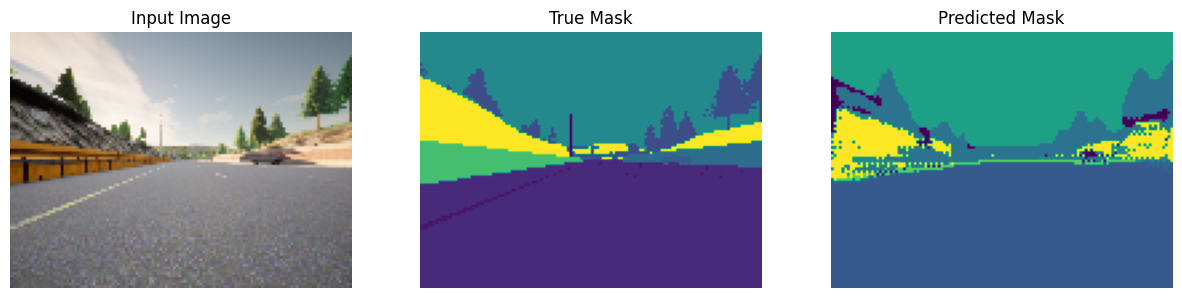

1/1 [==============================] - 0s 37ms/step


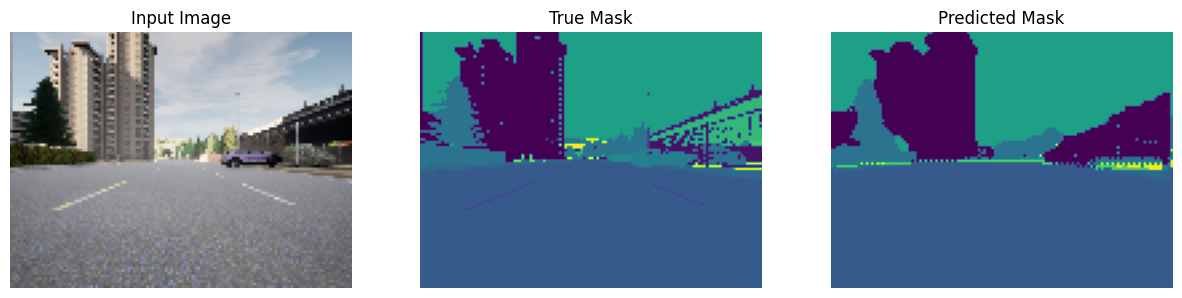

1/1 [==============================] - 0s 29ms/step


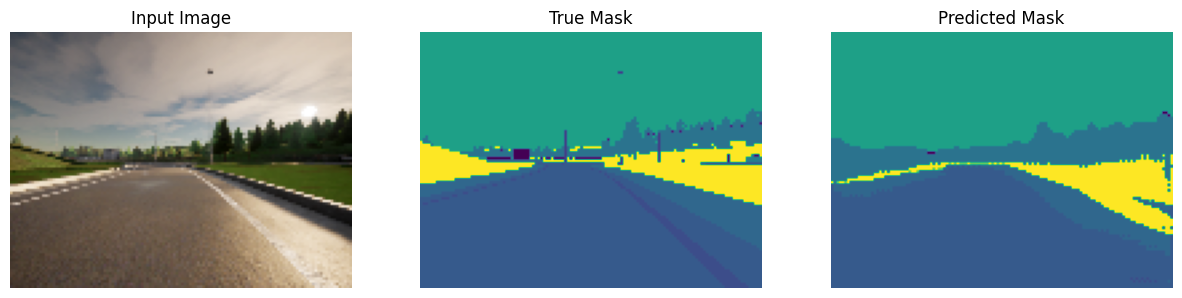

In [ ]:
show_predictions(train_dataset, 6)